# WAR!

This is my son Oscar.  He is five.  

<img style="max-width: 500px; height: auto; " src="oscar.jpg"/>

He recently learned how to play [war](https://en.wikipedia.org/wiki/War_(card_game)).  

The game is *not quite* deterministic, and actually *not quite* a game.  It's not really a game because it involves no choice on the part of the players, and it's not really deterministic, because the ordering of the winners cards, added to the bottom of their pile, is not determined by any rule.  

Naturally I became curious what the game's turn count distribution would look like.  You gotta figure that it's possible -- though very unlikely -- that it could resolve in a single turn:  one huge chain war.  It also seems plausible that it could go on infinitely; there would have to exist some combination of the initial ordering and orderings of all the win pots such that no player's pile ever goes all the way down to zero.  In practical terms, there's probably a very long right tail.

So let's see.  I'm going to import the class `War` from [war.py](https://github.com/cranedroesch/war/blob/main/war.py) -- which I wrote on an Amtrak train while Oscar played war with his mother -- and use it to simulate lots of games.  I'll then count their turn distribution, and see whether it corresponds with any known, stardard count distributions, like poisson or negative binomial or something.  I doubt it, but let's see.

In [1]:
from war import War, war_sim
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
from scipy.stats import poisson
import tensorflow as tf
from tensorflow_probability import distributions as tfd

Here's an example with verbose mode turned on.  I cherrypicked this seed to not have too big of a turn count.

In [2]:
game = War(verbose = True, seed = 26)
game.play()

Starting turn 1
10, 9, p1 wins [10, 9]
Adding pot [10, 9] to pile <queue.Queue object at 0x7fb1492f7c10> of size 25
Turn end status: turn 1 p1: 27, p2: 25
Starting turn 2
13, 10, p1 wins [13, 10]
Adding pot [13, 10] to pile <queue.Queue object at 0x7fb1492f7c10> of size 26
Turn end status: turn 2 p1: 28, p2: 24
Starting turn 3
11, 5, p1 wins [11, 5]
Adding pot [11, 5] to pile <queue.Queue object at 0x7fb1492f7c10> of size 27
Turn end status: turn 3 p1: 29, p2: 23
Starting turn 4
13, 2, p1 wins [13, 2]
Adding pot [13, 2] to pile <queue.Queue object at 0x7fb1492f7c10> of size 28
Turn end status: turn 4 p1: 30, p2: 22
Starting turn 5
5, 2, p1 wins [5, 2]
Adding pot [5, 2] to pile <queue.Queue object at 0x7fb1492f7c10> of size 29
Turn end status: turn 5 p1: 31, p2: 21
Starting turn 6
7, 3, p1 wins [7, 3]
Adding pot [7, 3] to pile <queue.Queue object at 0x7fb1492f7c10> of size 30
Turn end status: turn 6 p1: 32, p2: 20
Starting turn 7
8, 4, p1 wins [8, 4]
Adding pot [8, 4] to pile <queue.Que

52

Now we'll simulate lots of games.  

In [3]:
pool = mp.Pool(mp.cpu_count())
counts = pool.map(war_sim, range(50000))
pool.close()

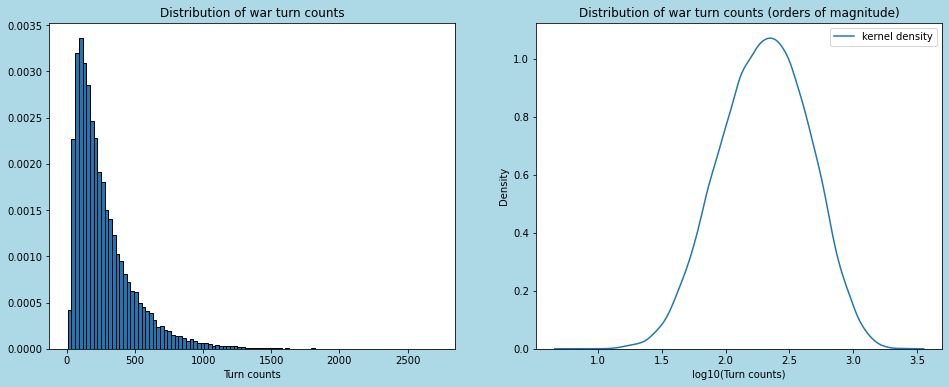

In [4]:
# I'm going to reuse this a lot...
def mainplot():
    fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))
    fig.patch.set_facecolor('lightblue')
    ax[0].hist(counts, edgecolor = 'black', density = True, bins = 100)
    ax[0].set_xlabel('Turn counts')
    ax[0].set_title('Distribution of war turn counts')
    sns.kdeplot(np.log10(counts), ax=ax[1], label = 'kernel density')
    ax[1].set_xlabel('log10(Turn counts)')
    ax[1].set_title('Distribution of war turn counts (orders of magnitude)')
    ax[1].legend()
    return fig, ax
fig, ax = mainplot()

## It is poisson?  
Doesn't really look like it.  But it's easy to check; poisson's single parameter is the mean of the counts.  

In [5]:
pmf = np.arange(poisson.ppf(0.01, np.mean(counts)),
                poisson.ppf(0.99, np.mean(counts)))
grid = list(range(min(counts), max(counts)))

In [6]:
def log10pmf(x: np.ndarray):
    '''
    take a pmf and transform it to be a valid pmf on the log10 scale
    '''
    y = 10**x
    y-=y.min()
    y/=y.sum()
    return y

In [7]:
log10pmf(poisson.pmf(grid, np.mean(counts))).sum()

1.0000000000000002

(0.0, 0.024458575221015896)

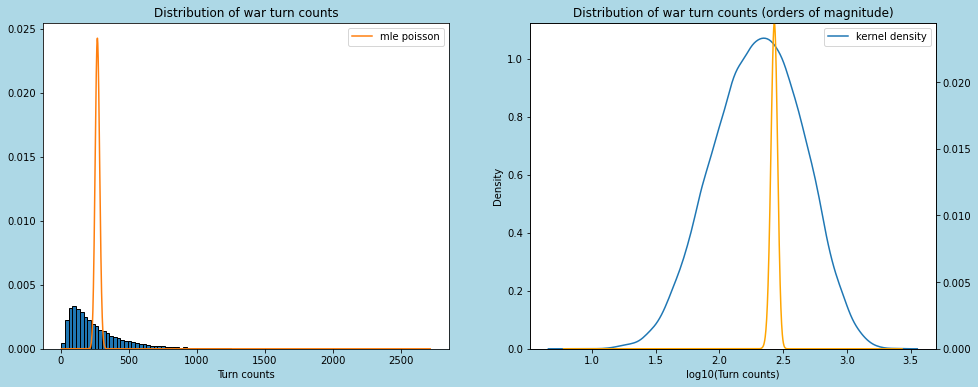

In [8]:
fig, ax = mainplot()
ax[0].plot(grid, poisson.pmf(grid, np.mean(counts)), label = 'mle poisson')
ax[0].legend()
cx1 = ax[1].twinx()
logpmf =log10pmf(poisson.pmf(grid, np.mean(counts)))
cx1.plot(np.log10(grid), logpmf, color = 'orange')
cx1.set_ylim(0, max(logpmf))


Nope

### Is it negative binomial?

It certainly isn't generated by the standard definition of the number of successes before $r$ failures, with the probability of each trial being $p$.  But let's give it a whirl and see if it's a good approximation.  I'm going to use tensorflow rather than scipy because (1) I've got tensorflow code lying around, and (2) why not?

In [9]:
r_init = 1.
p_init = .9
rate = tf.Variable([r_init])
prob = tf.Variable([p_init])
dist = tfd.NegativeBinomial(total_count = rate, probs = prob)
optimizer = tf.optimizers.Adam()

In [10]:
def loss(dist, data):
    total_log_prob = -tf.reduce_mean(dist.log_prob(data))
    return total_log_prob
     
def train_step(dist, data):
    with tf.GradientTape() as g:
        loss_value = loss(dist, data)
        grads = g.gradient(loss_value, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss_value

In [11]:
lossvec = []
for i in range(1000):
    lossvec.append(train_step(dist, counts))

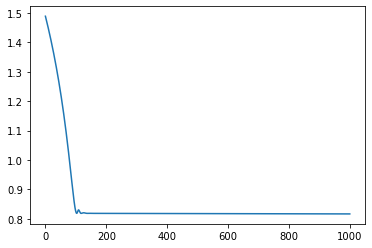

In [12]:
plt.plot(np.log10(lossvec))

Note that the loss should be near zero if these were in fact random draws from some negbin distribution; we've got a large sample, and there's no noise.

The estimates:

In [13]:

dist.trainable_variables

(<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.9954184], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.2453775], dtype=float32)>)

(0.0, 0.0028377037961035967)

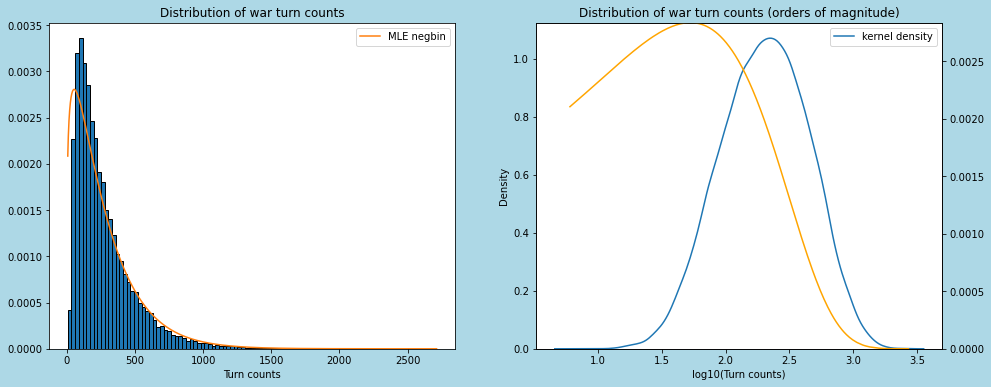

In [14]:
fig, ax = mainplot()
ax[0].plot(grid, dist.prob(grid), label = 'MLE negbin')
ax[0].legend()
cx1 = ax[1].twinx()
logpmf = log10pmf(dist.prob(grid).numpy())
cx1.plot(np.log10(grid), logpmf, color = 'orange')
cx1.set_ylim(0, max(logpmf))

Not bad, but not great.  It's not a negbin process.

## Maybe Gamma?  
It's a count variable, rather than a positive one.  But 

In [15]:
a_init = 10.
b_init = .1
alpha = tf.Variable([a_init])
beta = tf.Variable([b_init])
dist = tfd.Gamma(concentration = alpha, rate = beta)
optimizer = tf.optimizers.Adam()

In [16]:
def loss(dist, data):
    total_log_prob = -tf.reduce_mean(dist.log_prob(data))
    return total_log_prob
     
def train_step(dist, data):
    with tf.GradientTape() as g:
        loss_value = loss(dist, data)
        grads = g.gradient(loss_value, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss_value

In [17]:
lossvec = []
for i in range(5000):
    lossvec.append(train_step(dist, counts))

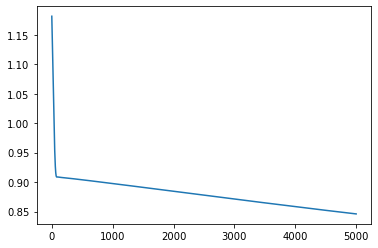

In [18]:
plt.plot(np.log10(lossvec))

Not done...

In [19]:
for i in range(5000):
    lossvec.append(train_step(dist, counts))

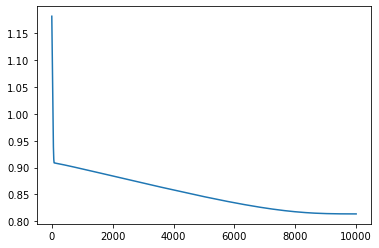

In [20]:
plt.plot(np.log10(lossvec))

A little more..

In [21]:
for i in range(1000):
    lossvec.append(train_step(dist, counts))

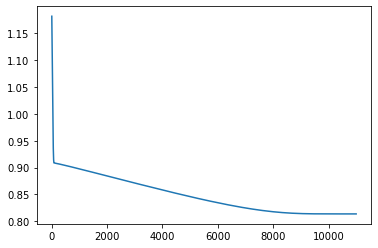

In [22]:
plt.plot(np.log10(lossvec))

In [23]:
dist.trainable_variables

(<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.8090765], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.00668677], dtype=float32)>)

(0.5141367238566568, 3.697624369850705, 0.9996897876262665, 1.006514459848404)

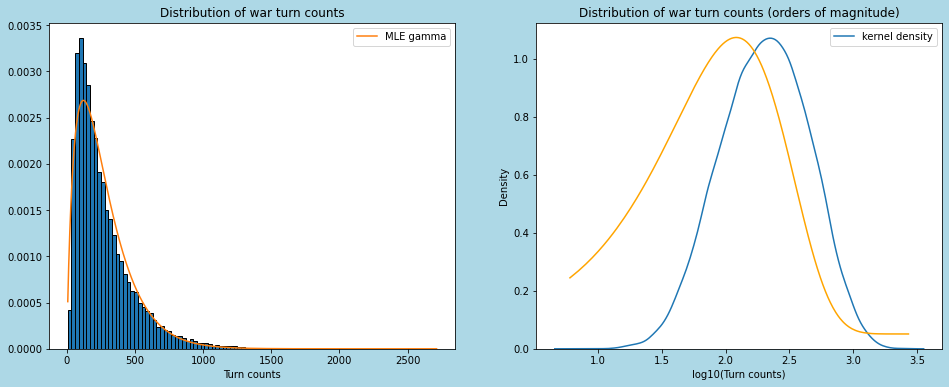

In [24]:
fig, ax = mainplot()
ax[0].plot(grid, dist.prob(grid), label = 'MLE gamma')
ax[0].legend()
cx1 = ax[1].twinx()
cx1.plot(np.log10(grid), 10**(dist.prob(grid)), color = 'orange')
cx1.axis('off')

### What have we learned?

We've learned that the turn counts in the game of war follows some distribution that isn't poisson, negative binomial, or gamma.  It's slightly left-skewed in log space, so it's not lognormal, that that probably wouldn't be a bad approximation.

What would the analytical distribution look like?  A mess, clearly.  It'd have to be the summation of the product of a bunch of probabilities player 1's card is greater than player 2's card, multiplied by the probability that either player has one card left, which itself would be, conditional on all preceeding terms.  And that's not thinking through what happens when there is a war.  You'd want to start with the simplest case:

$$
W(d = 2, n = 1)
$$

where $d$ is the deck size and the number of suits $n = 1$ guarantees that there will never be any wars.  You'd then generalize it.  

An analytical solution might be a cool project for the [Annals of Improbable Research](https://www.improbable.com/).

Hell, this might even be useful.  Who (among the people still reading) hasn't tried to fit a GLM to data that looks left-skewed when you log it?

In [25]:
! jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 18800 bytes to README.md
